In [2]:
from __future__ import division
import os
import functools
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import cPickle as pkl
import pandas as pd
import bb
from bb.tools.hist_tools_modified import hist
from bb.tools.bb_plotter import make_fit_plot, make_bb_plot
from scipy.stats import poisson

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams.update({'font.size': 20})

In [3]:
def calc_local_pvalue(N_bg, std_bg, N_sig, ntoys=1e7):
    print ''
    print 'Calculating local p-value and significance based on {0} toys...'.format(int(ntoys))
    toys    = np.random.normal(N_bg, std_bg, int(ntoys))
    pvars   = np.random.poisson(toys)
    pval    = pvars[pvars > N_bg + N_sig].size/pvars.size
    print 'local p-value = {0}'.format(pval)
    print 'local significance = {0:.2f}'.format(np.abs(norm.ppf(pval)))
    
    return pval

In [4]:
calc_local_pvalue(200,2,-10,1000)


Calculating local p-value and significance based on 1000 toys...
local p-value = 0.741
local significance = 0.65


0.741

# Amumu Bayesian Blocks Analysis

First, we will look at the 1b1f channel with no modifications.

In [5]:
# Load the channel
df = pd.read_csv('../../files/mass_values.dat', header=None, names=['Mass'])
bb_dir      = os.path.join(os.path.dirname(bb.__file__), '..')

# Assign random noise at the level of 1e-4 GeV to prevent duplicate events
np.random.seed(300)
df['Mass'] += np.random.normal(0,1e-5,size=len(df))
df = df.query('12<=Mass<=70')
xlimits=[12, 70]

In [6]:
len(df)

672

/Users/brianpollack/Coding/BayesianBlocks/bb/tools/hist_tools_modified.py:80: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/brianpollack/Coding/BayesianBlocks/bb/tools/hist_tools_modified.py:84: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/brianpollack/Coding/BayesianBlocks/bb/tools/hist_tools_modified.py:86: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/brianpollack/Coding/BayesianBlocks/bb/tools/hist_tools_modified.py:88: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/brianpollack/Coding/BayesianBlocks/bb/tools/hist_tools_modified.py:90: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will pe

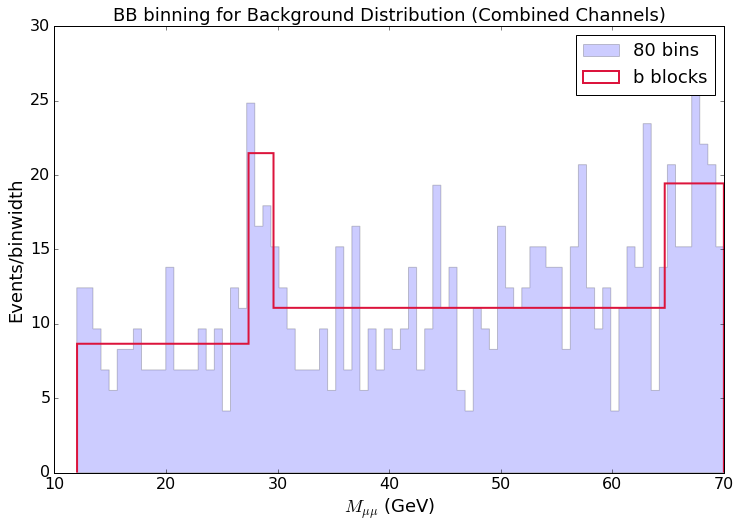

In [7]:
bc_data, be_data = make_bb_plot(df.Mass, 0.05, bb_dir+'/plots/', range=xlimits, scale='binwidth',
                title='BB binning for Background Distribution (Combined Channels)',
               xlabel=r'$M_{\mu\mu}$ (GeV)', ylabel='Events/binwidth', save_name='amumu_data_only')

The data forms 3 bins.  There is a single bin near the peak position.

In [8]:
print 'The bin edges'
print be_data

The bin edges
[ 12.02612708  27.39305101  29.62920976  64.68351946  69.98433206]


Now we'll make a binned signal model and combine it with the data.

In [9]:
np.random.seed(100)
signal_mc = np.random.normal(28.4, 1.18, size=40)

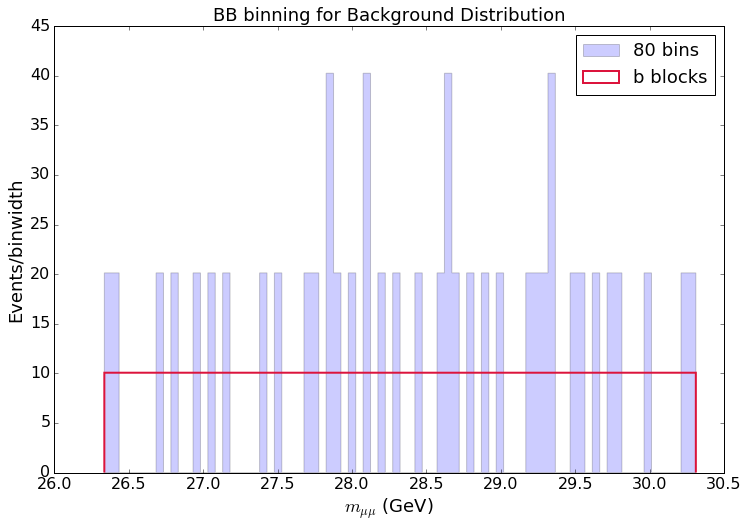

In [10]:
bc_sig, be_sig = make_bb_plot(signal_mc, 0.05, bb_dir+'/plots/', range=(min(signal_mc), max(signal_mc)), scale='binwidth',
                title='BB binning for Background Distribution',
               xlabel=r'$m_{\mu\mu}$ (GeV)', ylabel='Events/binwidth', save_name='amumu_signal_mc')

That's pretty easy.  Most rerolls of the random mc show either a single bin or two bins.  There are not yet enough signal events here to make a peaked distribution.  We'll combine this with the data to make a hybrid binning.

In [11]:
be_hybrid = np.concatenate([be_data[be_data<be_sig[0]], be_sig, be_data[be_data>be_sig[-1]]])

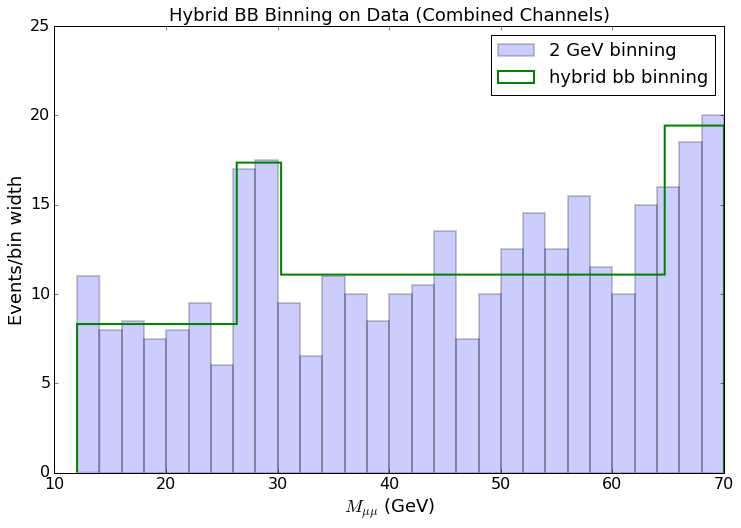

In [12]:
bc_bg_sig_2GeV, _, _ = hist(df.Mass,29,scale='binwidth', linewidth = 2, label='2 GeV binning', alpha=0.2)
bc_bg_sig_bb, _, _ = hist(df.Mass,be_hybrid,scale='binwidth', histtype='step', linewidth = 2, label='hybrid bb binning')
#bc_bg_sig, _, _ = hist(df.Mass,be_hybrid, histtype='step', linewidth = 2, label='hybrid bb binning')

plt.title('Hybrid BB Binning on Data (Combined Channels)')
plt.xlabel('$M_{\mu\mu}$ (GeV)')
plt.ylabel('Events/bin width')
plt.legend()
plt.show()

In [13]:
bc_bg_sig_bb

array([  8.31635721,  17.35795949,  11.08424222,  19.4309831 ])

In [14]:
be_sig

array([ 26.33527674,  30.31039836])

In [15]:
print 'region\t\tevents/GeV'
print
print 'sideband_low\t', bc_bg_sig_bb[0]
print 'sideband_high\t', bc_bg_sig_bb[2]
print 'signal\t\t', bc_bg_sig_bb[1]

region		events/GeV

sideband_low	8.31635721134
sideband_high	11.0842422167
signal		17.3579594876


In [16]:
sig_region_width = be_sig[1]-be_sig[0]
expected_evts_per_GeV_low = bc_bg_sig_bb[0]
expected_evts_per_GeV_hi = bc_bg_sig_bb[2]

expected_bg_low = sig_region_width*expected_evts_per_GeV_low
expected_bg_hi = sig_region_width*expected_evts_per_GeV_hi
observed_evts = sig_region_width*bc_bg_sig_bb[1]

print 'signal region width:\t', sig_region_width
print 'expected # events(low):\t', expected_bg_low
print 'expected # events (hi):\t', expected_bg_hi
print 'observed # events:\t', observed_evts


signal region width:	3.9751216178
expected # events(low):	33.0585313322
expected # events (hi):	44.0612108527
observed # events:	69.0


In [21]:
observed_evts = 68

In [22]:
p_val_low = 1-poisson.cdf(observed_evts, expected_bg_low)
z_low = np.abs(norm.ppf(p_val_low))

p_val_hi = 1-poisson.cdf(observed_evts, expected_bg_hi)
z_hi = np.abs(norm.ppf(p_val_hi))

print '\tp_val\t\tz-score'
print 'low bg\t', '{0:.3}'.format(p_val_low), '\t{0:.3}'.format(z_low)
print 'hi bg\t', '{0:.3}'.format(p_val_hi), '\t{0:.3}'.format(z_hi)


	p_val		z-score
low bg	3.26e-08 	5.4
hi bg	0.000307 	3.43


In [79]:
err_sb1 = np.sqrt((be_hybrid[1]-be_hybrid[0])*bc_bg_sig_bb[0])
err_sb2 = np.sqrt((be_hybrid[3]-be_hybrid[2])*bc_bg_sig_bb[2])
err_exp = np.sqrt((0.5**2)*(err_sb1**2)+(0.5**2)*(err_sb2**2))
pct_err_sb1 = err_sb1/((be_hybrid[1]-be_hybrid[0])*bc_bg_sig_bb[0])
pct_err_sb2 = err_sb2/((be_hybrid[3]-be_hybrid[2])*bc_bg_sig_bb[2])
ave_pct_err = (pct_err_sb1+pct_err_sb2)/2
print 'err sideband_low, % err\t', err_sb1, pct_err_sb1
print 'err sideband_high,% err\t', err_sb2, pct_err_sb2
print 'ave percent error\t', ave_pct_err
print 'err on expected evts\t', ave_pct_err*expected_evts
print 'sqrt of expected evts\t', np.sqrt(expected_evts)


err sideband_low, % err	10.9087121146 0.0916698497028
err sideband_high,% err	19.5192212959 0.0512315519579
ave percent error	0.0714507008303
err on expected evts	2.75512981348
sqrt of expected evts	6.20965949891


In [83]:
calc_local_pvalue(expected_evts, ave_pct_err*expected_evts, observed_evts-expected_evts, 1e8)


Calculating local p-value and significance based on 100000000 toys...
local p-value = 2.35e-05
local significance = 4.07


2.35e-05

In [1]:
from scipy.stats import poisson

In [4]:
p_cdf = poisson.cdf(69,38)

In [6]:
1-p_cdf

2.1317547146404436e-06

In [9]:
np.abs(norm.ppf(1-p_cdf))

4.5981050871756297